<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/polyhedral_constraints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install batch-iter pycddlib-standalone

# Framework for polyhedral cone layers

In [ ]:
import torch
from torch import nn

class MaskedActivation(nn.Module):
  def __init__(self, mask=None, activation=nn.ReLU):
    """
    Applies activation to (potentially) a subset of the input components.
    Args:
      mask: The mask of coordinates to which we should NOT apply the activation.
        `None` means applying the activation to all components. It is assumed
        that `mask` is a 1D tensor, that applies to the last dimension of the input
      activation: The activation to apply.
    """
    super().__init__()
    self.activation = activation()
    self.register_buffer('mask', mask)

  def forward(self, x):
    if self.mask is None:
      return self.activation(x)
    else:
      activated = self.activation(x[..., ~self.mask])
      result = x.masked_scatter(~self.mask, activated)
      return result

In [ ]:
activation = MaskedActivation(mask=torch.tensor([False, False, False, False, True, True]))
activation(torch.tensor([1., 2, -3, -4, -5, -6]))

tensor([ 1.,  2.,  0.,  0., -5., -6.])

In [ ]:
def frozen_linear(weights):
  in_dim, out_dim = weights.shape
  layer = nn.Linear(in_dim, out_dim, bias=False)
  layer.weight = nn.Parameter(weights, requires_grad=False)
  return layer

In [ ]:
def polyhedral_cone_module(generators, linear_mask=None, nonneg_activation=nn.ReLU):
  generators = generators / torch.linalg.vector_norm(generators, dim=0, keepdim=True)
  return nn.Sequential(
  	MaskedActivation(linear_mask, nonneg_activation),
    frozen_linear(generators)
  )

# Nondecreasing polyheral activation

In [ ]:
def nondecreasing_module(n):
  generators = torch.tril(torch.ones(n, n)) # the matrix of ones under the diagonal
  linear_mask = torch.zeros(n, dtype=bool)
  linear_mask[0] = True
  return polyhedral_cone_module(generators, linear_mask)

In [ ]:
n = 8
mod = nondecreasing_module(n)

torch.manual_seed(42)
print(mod(torch.randn(n)))
print(mod(torch.randn(n)))
print(mod(torch.randn(n)))

tensor([0.1190, 0.1677, 0.2634, 0.3665, 0.3665, 0.3665, 1.9279, 1.9279])
tensor([0.1632, 0.2643, 0.4826, 0.8446, 1.3997, 1.3997, 1.3997, 2.3577])
tensor([0.4674, 0.7763, 0.7763, 0.7763, 1.4526, 1.8488, 1.8488, 2.6438])


In [ ]:
import numpy as np
import cdd

def make_cdd_cone(A):
  """Creates a libcdd polyhedral cone given the matrix describing the inequalities A x ≥ 0. """
  # define the RHS of the inequalities. In our case - everything is ≥ 0
  b = np.zeros((A.shape[0], 1))

  # the library operates assuming we describe inequalities in the form:
  #    b + A x ≥ 0
  # and expects b and A to be concatenated into one big matrix.
  Ab = np.hstack([b, A])

  # create and print the polyhedral cone object
  mat = cdd.matrix_from_array(Ab, rep_type=cdd.RepType.INEQUALITY)
  poly = cdd.polyhedron_from_matrix(mat)
  return poly

# polyhedral cone for non-decreasing sequences:
cone = make_cdd_cone(np.array(
    [[-1,  1,  0,  0,  0,  0,  0,  0],
     [ 0, -1,  1,  0,  0,  0,  0,  0],
     [ 0,  0, -1,  1,  0,  0,  0,  0],
     [ 0,  0,  0, -1,  1,  0,  0,  0],
     [ 0,  0,  0,  0, -1,  1,  0,  0],
     [ 0,  0,  0,  0,  0, -1,  1,  0],
     [ 0,  0,  0,  0,  0,  0, -1,  1]]))
print(cone)

begin
 7 9 real
  0 -1  1  0  0  0  0  0  0
  0  0 -1  1  0  0  0  0  0
  0  0  0 -1  1  0  0  0  0
  0  0  0  0 -1  1  0  0  0
  0  0  0  0  0 -1  1  0  0
  0  0  0  0  0  0 -1  1  0
  0  0  0  0  0  0  0 -1  1
end


In [ ]:
generators = cdd.copy_generators(cone)
print(generators)

V-representation
linearity 1  8
begin
 8 9 real
  0 -1  0  0  0  0  0  0  0
  0 -1 -1  0  0  0  0  0  0
  0 -1 -1 -1  0  0  0  0  0
  0 -1 -1 -1 -1  0  0  0  0
  0 -1 -1 -1 -1 -1  0  0  0
  0 -1 -1 -1 -1 -1 -1  0  0
  0 -1 -1 -1 -1 -1 -1 -1  0
  0  1  1  1  1  1  1  1  1
end


In [ ]:
def print_generators(cone):
  generators = cdd.copy_generators(cone)
  print('Linear generators: ', generators.lin_set)
  print('Generator matrix: ')
  gen_mat = np.array(generators.array)
  gen_mat = gen_mat[:, 1:] # discard the first column of zeros
  gen_mat = gen_mat.T
  print(gen_mat)

print_generators(cone)

Linear generators:  {7}
Generator matrix: 
[[-1. -1. -1. -1. -1. -1. -1.  1.]
 [ 0. -1. -1. -1. -1. -1. -1.  1.]
 [ 0.  0. -1. -1. -1. -1. -1.  1.]
 [ 0.  0.  0. -1. -1. -1. -1.  1.]
 [ 0.  0.  0.  0. -1. -1. -1.  1.]
 [ 0.  0.  0.  0.  0. -1. -1.  1.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


# Nonincreasing polyhedral activation

In [ ]:
# print generators for non-increasing sequences
# note - the matrix is exactly the negated matrix of non-decreasing sequences
# we used above.
cone = print_generators(make_cdd_cone(np.array(
    [[1,  -1,  0,  0,  0,  0,  0,  0],
     [ 0, 1,  -1,  0,  0,  0,  0,  0],
     [ 0,  0, 1,  -1,  0,  0,  0,  0],
     [ 0,  0,  0, 1,  -1,  0,  0,  0],
     [ 0,  0,  0,  0, 1,  -1,  0,  0],
     [ 0,  0,  0,  0,  0, 1,  -1,  0],
     [ 0,  0,  0,  0,  0,  0, 1,  -1]])))

Linear generators:  {7}
Generator matrix: 
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
def nonincreasing_module(n):
  generators = torch.triu(torch.ones(n, n))

  linear_mask = torch.zeros(n, dtype=bool)
  linear_mask[n-1] = True # the last generator is linear

  return polyhedral_cone_module(generators, linear_mask)

In [ ]:
n = 8
mod = nonincreasing_module(n)

torch.manual_seed(42)
print(mod(torch.randn(n)))
print(mod(torch.randn(n)))
print(mod(torch.randn(n)))

tensor([ 1.2874,  0.9507,  0.8596,  0.7242,  0.6091,  0.6091,  0.6091, -0.2256])
tensor([2.1994, 1.7378, 1.5487, 1.2399, 0.8352, 0.3387, 0.3387, 0.3387])
tensor([3.0661, 1.7440, 1.1661, 1.1661, 1.1661, 0.5613, 0.2811, 0.2811])


# Convex sequences



In [ ]:
# print generators for a convex sequence
cone = print_generators(make_cdd_cone(np.array(
    [[1,  -2,  1,  0,  0,  0,  0,  0],
     [ 0, 1,  -2,  1,  0,  0,  0,  0],
     [ 0,  0, 1,  -2,  1,  0,  0,  0],
     [ 0,  0,  0, 1,  -2,  1,  0,  0],
     [ 0,  0,  0,  0, 1,  -2,  1,  0],
     [ 0,  0,  0,  0,  0, 1,  -2,  1]])))

Linear generators:  {6, 7}
Generator matrix: 
[[ 1.  2.  3.  4.  5.  6.  7. -6.]
 [ 0.  1.  2.  3.  4.  5.  6. -5.]
 [ 0.  0.  1.  2.  3.  4.  5. -4.]
 [ 0.  0.  0.  1.  2.  3.  4. -3.]
 [ 0.  0.  0.  0.  1.  2.  3. -2.]
 [ 0.  0.  0.  0.  0.  1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


Convex sequence generator pattern
$$
\left(
\begin{array}{ccccc|c}
1 & 2 & 3 & \dots & n - 1 & -(n - 2) \\
0 & 1 & 2 & \dots & n - 2 & -(n - 3) \\
\vdots & \ddots & \ddots & 1 & 2 & -1 \\
0 & 0 & \dots & 0 & 1 & 0 \\
\hline
0 & 0 & \dots & 0 & 0 & 1
\end{array}
\right)
$$
The top-left block is a triangular matrix of arithmetic progressions. The top-right block is a column of increasing numbers from $-(n-2)$ up to $0$. The bottom-left block is zeros, and the bottom-right block is a one. Overall, the matrix is a square $n \times n$ matrix.

In [ ]:
def make_convex_generators(n):
  top_left = torch.cumsum(torch.triu(torch.ones((n - 1, n - 1))), dim=1)
  top_right = torch.arange(-(n-2), 1).reshape(-1, 1)
  top = torch.cat([top_left, top_right], dim=1)

  bottom_left = torch.zeros((1, n - 1))
  bottom_right = torch.ones((1, 1))
  bottom = torch.cat([bottom_left, bottom_right], dim=1)

  generators = torch.cat([top, bottom], dim=0)
  return generators

make_convex_generators(8)

tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7., -6.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6., -5.],
        [ 0.,  0.,  1.,  2.,  3.,  4.,  5., -4.],
        [ 0.,  0.,  0.,  1.,  2.,  3.,  4., -3.],
        [ 0.,  0.,  0.,  0.,  1.,  2.,  3., -2.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  2., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [ ]:
def convex_module(n):
  generators = make_convex_generators(n)
  linear_mask = torch.zeros(n, dtype=bool)
  linear_mask[-2:] = True
  return polyhedral_cone_module(generators, linear_mask)

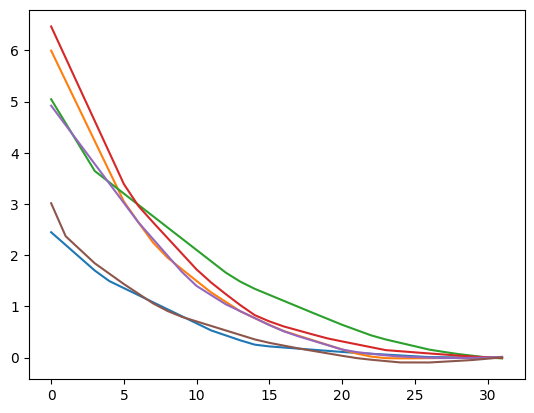

In [ ]:
import matplotlib.pyplot as plt

n = 32
layer = convex_module(n)

torch.manual_seed(56)
for i in range(6):
  t = torch.randn(n)
  plt.plot(layer(t))
plt.show()

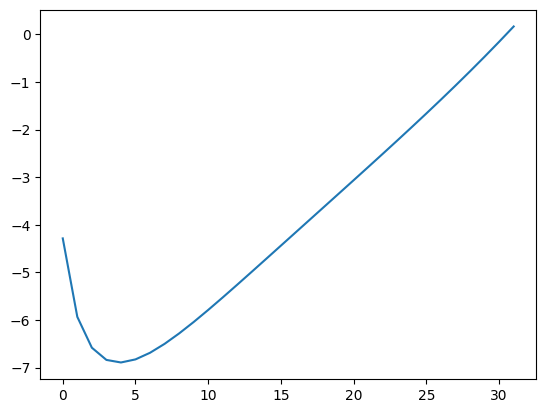

In [ ]:
t = (torch.linspace(-1, 1, n)).square()
t[-1] = n / 2
t[-2] = -n / 2
plt.plot(layer(t))

# Concave sequences

In [ ]:
# print generators for a convex sequence
cone = print_generators(make_cdd_cone(np.array(
    [[-1,  2,  -1,  0,  0,  0,  0,  0],
     [ 0, -1,  2,  -1,  0,  0,  0,  0],
     [ 0,  0, -1,  2,  -1,  0,  0,  0],
     [ 0,  0,  0, -1,  2,  -1,  0,  0],
     [ 0,  0,  0,  0, -1,  2,  -1,  0],
     [ 0,  0,  0,  0,  0, -1,  2,  -1]])))

Linear generators:  {6, 7}
Generator matrix: 
[[-1. -2. -3. -4. -5. -6.  7. -6.]
 [ 0. -1. -2. -3. -4. -5.  6. -5.]
 [ 0.  0. -1. -2. -3. -4.  5. -4.]
 [ 0.  0.  0. -1. -2. -3.  4. -3.]
 [ 0.  0.  0.  0. -1. -2.  3. -2.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


In [ ]:
def make_concave_generators(n):
  top_left = torch.cumsum(torch.triu(torch.ones((n - 1, n - 1))), dim=1)
  top_right = torch.arange(-(n-2), 1).reshape(-1, 1)
  top = torch.cat([top_left, top_right], dim=1)

  bottom_left = torch.zeros((1, n - 1))
  bottom_right = torch.ones((1, 1))
  bottom = torch.cat([bottom_left, bottom_right], dim=1)

  mat = torch.cat([top, bottom], dim=0)
  mat[:n-2, :n-2] *= -1
  return mat

make_concave_generators(8)

tensor([[-1., -2., -3., -4., -5., -6.,  7., -6.],
        [-0., -1., -2., -3., -4., -5.,  6., -5.],
        [-0., -0., -1., -2., -3., -4.,  5., -4.],
        [-0., -0., -0., -1., -2., -3.,  4., -3.],
        [-0., -0., -0., -0., -1., -2.,  3., -2.],
        [-0., -0., -0., -0., -0., -1.,  2., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [ ]:
def concave_module(n):
  generators = make_concave_generators(n)
  linear_mask = torch.zeros(n, dtype=bool)
  linear_mask[-2:] = True
  return polyhedral_cone_module(generators, linear_mask)

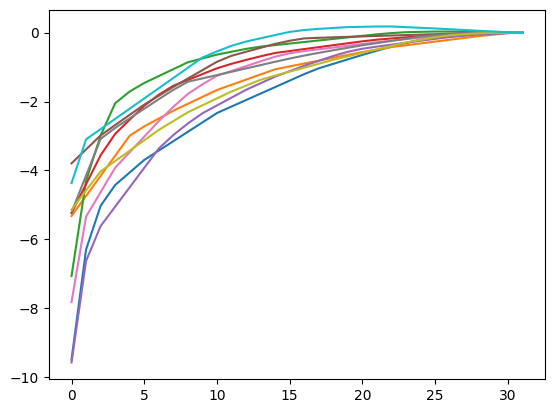

In [ ]:
n = 32
layer = concave_module(n)

torch.manual_seed(42)
for i in range(10):
  t = torch.randn(n)
  plt.plot(layer(t))
plt.show()

# Concave increasing increasing

In [ ]:
# print generators for concave non-decreasing sequences
print_generators(make_cdd_cone(np.array(
    [[-1,  2,  -1,  0,  0,  0,  0,  0],
     [ 0, -1,  2,  -1,  0,  0,  0,  0],
     [ 0,  0, -1,  2,  -1,  0,  0,  0],
     [ 0,  0,  0, -1,  2,  -1,  0,  0],
     [ 0,  0,  0,  0, -1,  2,  -1,  0],
     [ 0,  0,  0,  0,  0, -1,  2,  -1],
     [-1,  1,  0,  0,  0,  0,  0,   0],
     [ 0, -1,  1,  0,  0,  0,  0,   0],
     [ 0,  0, -1,  1,  0,  0,  0,   0],
     [ 0,  0,  0, -1,  1,  0,  0,   0],
     [ 0,  0,  0,  0, -1,  1,  0,   0],
     [ 0,  0,  0,  0,  0, -1,  1,   0],
     [ 0,  0,  0,  0,  0,  0, -1,   1]]
    )))

Linear generators:  {7}
Generator matrix: 
[[-7. -6. -5. -4. -3. -2. -1.  1.]
 [-6. -5. -4. -3. -2. -1.  0.  1.]
 [-5. -4. -3. -2. -1.  0.  0.  1.]
 [-4. -3. -2. -1.  0.  0.  0.  1.]
 [-3. -2. -1.  0.  0.  0.  0.  1.]
 [-2. -1.  0.  0.  0.  0.  0.  1.]
 [-1.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


In [ ]:
def concave_nondecreasing_generators(n):
  generators = -torch.ones(n, n).triu(1).cumsum(dim=1).fliplr()
  generators[:, -1] = torch.ones(n)
  return generators

concave_nondecreasing_generators(8)

tensor([[-7., -6., -5., -4., -3., -2., -1.,  1.],
        [-6., -5., -4., -3., -2., -1., -0.,  1.],
        [-5., -4., -3., -2., -1., -0., -0.,  1.],
        [-4., -3., -2., -1., -0., -0., -0.,  1.],
        [-3., -2., -1., -0., -0., -0., -0.,  1.],
        [-2., -1., -0., -0., -0., -0., -0.,  1.],
        [-1., -0., -0., -0., -0., -0., -0.,  1.],
        [-0., -0., -0., -0., -0., -0., -0.,  1.]])

In [ ]:
def concave_nondecreasing_cone_module(n):
  generators = concave_nondecreasing_generators(n)
  linear_mask = torch.zeros(n, dtype=bool)
  linear_mask[-1] = True
  return polyhedral_cone_module(generators, linear_mask)

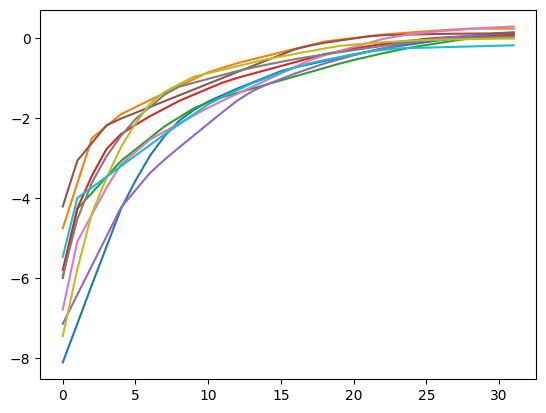

In [ ]:
n = 32
layer = concave_nondecreasing_cone_module(n)

torch.manual_seed(42)
for i in range(10):
  t = torch.randn(n)
  plt.plot(layer(t))
plt.show()

# Bernstein shape-constrained module

In [ ]:
def log_binom_coef(n: torch.Tensor, k: torch.Tensor):
  return (
      torch.lgamma(n + 1)
      - torch.lgamma(k + 1)
      - torch.lgamma(n - k + 1)
  )

In [ ]:
n = torch.tensor(5)
k = torch.arange(6)
print(log_binom_coef(n, k).exp())

tensor([ 1.,  5., 10., 10.,  5.,  1.])


In [ ]:
def bernstein_basis(degree: int, z: torch.Tensor):
  """
  Computes a matrix containing the Bernstein basis of a given degree, where
  each row corresponds to an entry in the input tensor `z`.
  """

  # entries of `z` in rows, and basis indices in columns
  z = z.view(-1, 1)
  ks = torch.arange(degree + 1, device=z.device).view(1, -1)

  # degree in a tensor to call log_binom_coef
  degree_tensor = torch.as_tensor(degree, device=z.device)

  # now we compute the Bernstein basis by definition
  binom_coef = torch.exp(log_binom_coef(degree_tensor, ks))
  return binom_coef * (z ** ks) * ((1 - z) ** (degree_tensor - ks))

In [ ]:
from torch import nn

class BernsteinPolynomialModel(nn.Module):
  def __init__(self, x_model, coef_transformer):
    super().__init__()
    self.x_model = x_model
    self.coef_transformer = coef_transformer

  def forward(self, x, z):
    coefs = self.coef_transformer(self.x_model(x))
    degree = coefs.shape[-1] - 1
    basis = bernstein_basis(degree, z)
    return torch.sum(coefs * basis, dim=-1)

# Fitting concave nondecreasing function

In [ ]:
import numpy as np

def np_softplus(x):
  return np.log1p(np.exp(x))

def hairy_concave_func(x, z):
  x1, x2, x3 = x[..., 0], x[..., 1], x[..., 2]
  return np_softplus(x1) * np.sqrt(0.05 + z) - np_softplus(x3) * (z - np.cos(x2) ** 2) ** 2

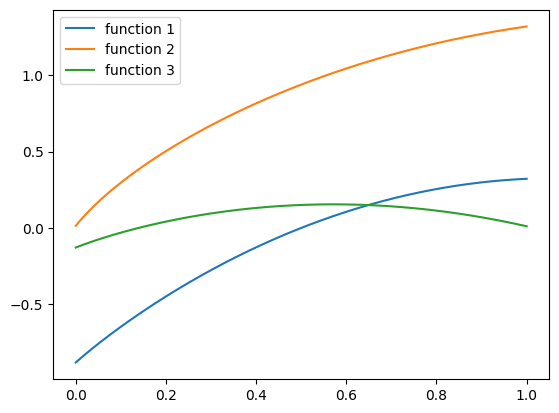

In [ ]:
import matplotlib.pyplot as plt

zs = np.linspace(0, 1, 1000)
plt.plot(zs, hairy_concave_func(np.array([-1, 0.1, 0.5]), zs), label='function 1')
plt.plot(zs, hairy_concave_func(np.array([1, 0.5, -0.5]), zs), label='function 2')
plt.plot(zs, hairy_concave_func(np.array([-1.5, 0.8, 0.1]), zs), label='function 3')
plt.legend()
plt.show()

In [ ]:
def make_model(layer_dims, constrained=True):
  # create a fully connected ReLU network
  layers = [
      layer
      for in_dim, out_dim in zip(layer_dims[:-1], layer_dims[1:])
      for layer in [nn.Linear(in_dim, out_dim), nn.ReLU()]
  ]

  if constrained:
    # define a model for x
    x_model = nn.Sequential(*layers[:-1])

    # construct a network for predicting non-decreasing functions
    # the polynomial degree is the output dimension of the last
    # layer.
    return BernsteinPolynomialModel(
        x_model,
        concave_module(layer_dims[-1])
    )
  else:
    layers.append(nn.Linear(layer_dims[-1], 1))
    return nn.Sequential(*layers)

In [ ]:
from tqdm.auto import tqdm

def train_epoch(data_iter, model, loss_fn, optim, constrained):
  for x, z, label in data_iter:
    if constrained:
      pred = model(x, z)
    else:
      pred = model(torch.cat([x, z.reshape(-1, 1)], dim=-1)).squeeze()
    loss = loss_fn(pred, label)

    optim.zero_grad()
    loss.backward()
    optim.step()


@torch.no_grad()
def evaluate_epoch(data_iter, model, loss_fn, constrained):
  epoch_loss = 0.
  num_samples = 0
  for x, z, label in data_iter:
    if constrained:
      pred = model(x, z)
    else:
      pred = model(torch.cat([x, z.reshape(-1, 1)], dim=-1)).squeeze()
    loss = loss_fn(pred, label)
    epoch_loss += loss * label.size(0)
    num_samples += label.size(0)
  return epoch_loss.cpu().item() / num_samples


def train_model(train_iter, valid_iter, layer_dims, constrained=True,
                optim_fn=torch.optim.SGD, optim_params=None, num_epochs=100):
  if optim_params is None:
    optim_params = {}

  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  model = make_model(layer_dims, constrained=constrained)
  optim = optim_fn(model.parameters(), **optim_params)
  loss_fn = nn.MSELoss()

  if torch.cuda.is_available():
    model = model.cuda()

  with tqdm(range(num_epochs)) as epoch_range:
    for epoch in epoch_range:
      train_epoch(train_iter, model, loss_fn, optim, constrained)
      epoch_loss = evaluate_epoch(valid_iter, model, loss_fn, constrained)
      epoch_range.set_description(f'Validation loss = {epoch_loss:.5f}')
  return model, epoch_loss

In [ ]:
def generate_dataset(n_rows, noise=0.02, mean=0, std=1):
  xs = std * np.random.randn(n_rows, 3) + mean
  zs = np.random.rand(n_rows)
  labels = hairy_concave_func(xs, zs) + np.random.randn(n_rows) * noise

  xs = torch.as_tensor(xs).to(dtype=torch.float32)
  zs = torch.as_tensor(zs).to(dtype=torch.float32)
  labels = torch.as_tensor(labels).to(dtype=torch.float32)
  if torch.cuda.is_available():
    xs = xs.cuda()
    zs = zs.cuda()
    labels = labels.cuda()

  return xs, zs, labels

In [ ]:
from batch_iter import BatchIter

batch_size = 256
train_iter = BatchIter(*generate_dataset(50000), batch_size=batch_size)
valid_iter = BatchIter(*generate_dataset(10000), batch_size=batch_size)

In [ ]:
lr = 1e-3
weight_decay = 0.
degree = 20
layer_dims = [3,
              4 * degree,
              3 * degree,
              2 * degree,
              degree]
model, val_loss = train_model(
    train_iter, valid_iter, layer_dims,
    optim_fn=torch.optim.AdamW,
    optim_params=dict(lr=lr, weight_decay=weight_decay))
model = model.cpu()

  0%|          | 0/100 [00:00<?, ?it/s]

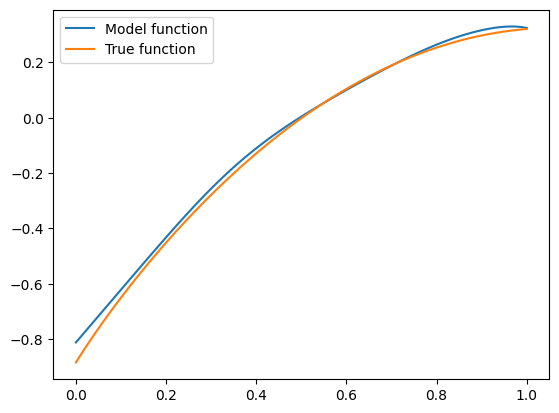

In [ ]:
from functools import partial

plot_zs = torch.linspace(0, 1, 100)
features = torch.tensor([-1, 0.1, 0.5]).repeat(100, 1)
func = partial(model, features)
plt.plot(plot_zs, func(plot_zs).detach().numpy(), label='Model function')
plt.plot(plot_zs, hairy_concave_func(features.numpy(), plot_zs.numpy()), label='True function')

plt.legend()
plt.show()

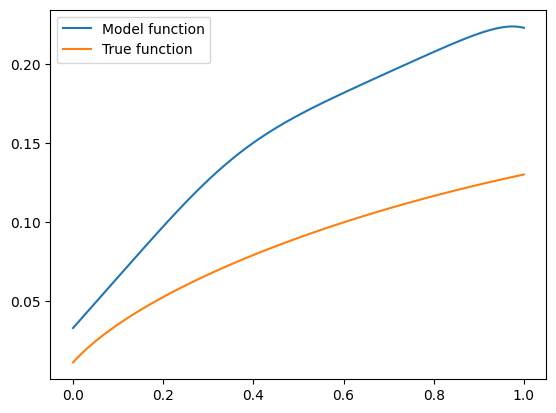

In [ ]:
features = torch.tensor([-2., -3., -4.]).repeat(100, 1)
func = partial(model, features)
plt.plot(plot_zs, func(plot_zs).detach().numpy(), label='Model function')
plt.plot(plot_zs, hairy_concave_func(features.numpy(), plot_zs.numpy()), label='True function')

plt.legend()
plt.show()

In [ ]:
lr = 1e-3
weight_decay = 0.
degree = 20
layer_dims = [4,
              4 * degree,
              3 * degree,
              2 * degree,
              degree]
unconstrained_model, val_loss = train_model(
    train_iter, valid_iter, layer_dims, constrained=False,
    optim_fn=torch.optim.AdamW,
    optim_params=dict(lr=lr, weight_decay=weight_decay))
unconstrained_model = unconstrained_model.cpu()

  0%|          | 0/100 [00:00<?, ?it/s]

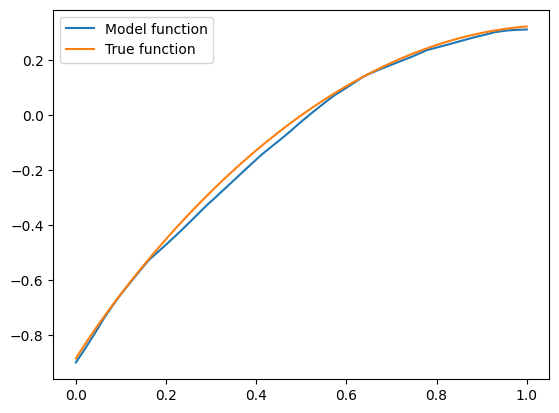

In [ ]:
features = torch.cat([
    torch.tensor([-1, 0.1, 0.5]).repeat(100, 1),
    plot_zs.reshape(-1, 1)
], axis=-1)
plt.plot(plot_zs, unconstrained_model(features).detach().numpy(), label='Model function')
plt.plot(plot_zs, hairy_concave_func(features.numpy(), plot_zs.numpy()), label='True function')

plt.legend()
plt.show()

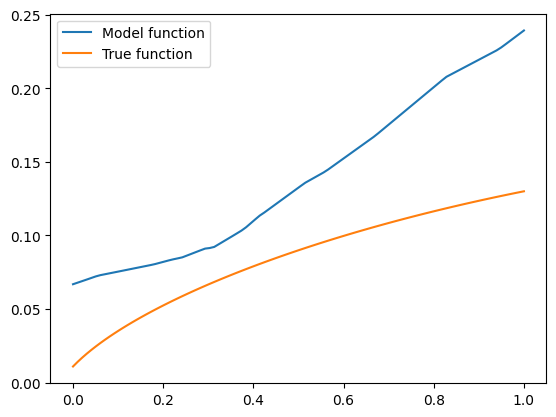

In [ ]:
features = torch.cat([
    torch.tensor([-2., -3., -4.]).repeat(100, 1),
    plot_zs.reshape(-1, 1)
], axis=-1)
plt.plot(plot_zs, unconstrained_model(features).detach().numpy(), label='Model function')
plt.plot(plot_zs, hairy_concave_func(features.numpy(), plot_zs.numpy()), label='True function')

plt.legend()
plt.show()